In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import os
import sys
import subprocess

In [4]:
# Load dataset
df = pd.read_csv("../data/raw/global_electricity_production_data.csv")

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

print(df.info())
print(df['product'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121074 entries, 0 to 121073
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country_name  121074 non-null  object        
 1   date          121074 non-null  datetime64[ns]
 2   parameter     121074 non-null  object        
 3   product       121074 non-null  object        
 4   value         121060 non-null  float64       
 5   unit          121074 non-null  object        
 6   year          121074 non-null  int32         
 7   month         121074 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), object(4)
memory usage: 6.5+ MB
None
['Electricity' 'Total Combustible Fuels'
 'Coal, Peat and Manufactured Gases' 'Oil and Petroleum Products'
 'Natural Gas' 'Combustible Renewables' 'Hydro' 'Wind' 'Solar'
 'Total Renewables (Hydro, Geo, Solar, Wind, Other)'
 'Other Combustible Non-Renewables' 'Geothermal' 'Not Specified' 'Nucle

## Feature: `product`
**Definition:**  
Indicates the **energy source** or **fuel type** used to produce electricity, measured in **GWh (Gigawatt-hours)**.

Electricity generation data in this dataset comes from the IEA’s *World Energy Balances* and related open data series, which track net production by energy source across all reporting countries and months.

---

### Product Categories and Descriptions

| **Product Name** | **Description** |
|------------------|------------------|
| **Electricity** | Total electricity generation from all sources. Serves as the aggregate sum across all fuel types. |
| **Total Combustible Fuels** | Combined generation from all fossil and bio-based fuels: coal, oil, natural gas, and biofuels. Represents thermal generation. |
| **Coal, Peat and Manufactured Gases** | Generation from coal-based fuels (hard coal, lignite, peat) and derived gases like coke oven gas or blast furnace gas. High CO₂ intensity. |
| **Oil and Petroleum Products** | Electricity produced from crude oil and refined petroleum fuels (diesel, heavy fuel oil, etc.). Often used for backup generation. |
| **Natural Gas** | Power generated from natural gas combustion. Lower CO₂ intensity than coal or oil, often used in combined-cycle plants. |
| **Biofuels and Waste** | Generation from solid biomass, biogas, municipal waste, and industrial waste. Includes renewable and non-renewable portions depending on feedstock. |
| **Hydro** | Electricity generated by hydropower plants using water flow through turbines. Renewable, dispatchable, but climate-dependent. |
| **Geothermal** | Electricity from underground heat sources (steam or hot water reservoirs). Low emissions, constant base-load output. |
| **Solar Photovoltaic** | Generation from photovoltaic (PV) cells converting sunlight directly into electricity. Intermittent, zero direct emissions. |
| **Solar Thermal** | Electricity from concentrated solar power (CSP) plants that use mirrors to generate heat for turbines. Renewable but geographically limited. |
| **Wind** | Power produced from wind turbines converting kinetic wind energy to electricity. Intermittent and weather-dependent. |
| **Tide, Wave and Ocean** | Experimental or small-scale generation from oceanic sources: tidal streams, waves, ocean currents, and thermal gradients. Renewable and location-specific. |
| **Nuclear** | Electricity generated through controlled nuclear fission reactions. Low CO₂ but includes waste and safety concerns. |
| **Other Sources** | Any other minor or unspecified electricity sources (e.g., hydrogen, synthetic fuels, pilot technologies). Typically small in share. |

---

### Analytical Relevance

| **Cluster Feature** | **Use in Analysis** |
|----------------------|--------------------|
| Fossil-based categories (Coal, Oil, Gas) | Measure carbon intensity and fossil dependence. |
| Renewable categories (Hydro, Wind, Solar, Geothermal, Tide) | Represent clean and sustainable generation capacity. |
| Transitional sources (Biofuels and Waste) | Capture mixed renewable/non-renewable generation. |
| Nuclear | Indicates low-carbon but non-renewable pathway reliance. |
| Aggregate totals | Used for normalization and consistency checks before computing generation shares. |

---

### Notes
- Some countries may not report all categories (missing = 0 or unmeasured).
- “Electricity” and “Total Combustible Fuels” are aggregate metrics and should not both be used as features in clustering (to avoid redundancy).
- Shares should always be normalized per country to total generation (100%) for comparability.

---

**Summary:**  
The `product` feature defines **what energy source** contributed to each record’s reported electricity production.  
In clustering, these categories form the **dimensions** of a country’s **energy-mix profile**, enabling comparison of fossil-heavy, renewable-dominant, and transition-stage energy systems worldwide.

In [5]:


# Identify the latest complete year in the dataset
latest_year = df['year'].max()
print(f"Latest year in dataset: {latest_year}")

# Filter to that year
df_latest = df[df['year'] == latest_year].copy()

# Aggregate by country and energy product
aggregated = (
    df_latest
    .groupby(['country_name', 'product'])
    .agg(
        total_GWh=('value', 'sum'),
        avg_GWh=('value', 'mean'),
        std_GWh=('value', 'std'),
        months_reported=('month', 'nunique')
    )
    .reset_index()
)

# Pivot to wide format for clustering later
aggregated_pivot = aggregated.pivot_table(
    index='country_name',
    columns='product',
    values='total_GWh',
    fill_value=0
)

print(aggregated_pivot.info())

Latest year in dataset: 2023
<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Argentina to United States
Data columns (total 16 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Coal, Peat and Manufactured Gases                  48 non-null     float64
 1   Combustible Renewables                             48 non-null     float64
 2   Data is estimated for this month                   48 non-null     float64
 3   Electricity                                        48 non-null     float64
 4   Geothermal                                         48 non-null     float64
 5   Hydro                                              48 non-null     float64
 6   Natural Gas                                        48 non-null     float64
 7   Not Specified                                      48 non-null     float64
 8   Nuclear                                          

## Why We Aggregated Across a Year

### Context
The raw dataset includes **monthly electricity generation values** for each **country and energy source**.  
To analyze national energy systems and perform clustering, we needed to represent **each country with a single, stable profile** rather than fluctuating monthly data.

---

### Rationale for Annual Aggregation

1. **Remove Seasonal Noise**
   - Monthly values capture short-term variability (e.g., hydro peaks, solar dips).
   - Annual totals smooth out seasonal fluctuations, highlighting *structural differences* between energy systems.

2. **Ensure Cross-Country Comparability**
   - Countries operate in different hemispheres and climates, so comparing January vs. July is misleading.
   - Aggregating to yearly totals ensures all countries are evaluated over the *same full production cycle*.

3. **Reflect Policy-Relevant Metrics**
   - Energy transition decisions are based on *annual generation shares* (e.g., % renewable electricity per year), not monthly patterns.
   - Policymakers use yearly data for SDG 7 and SDG 13 reporting and investment planning.

4. **Simplify Clustering Features**
   - Aggregation condenses 12×N observations into one record per country, enabling clustering on stable features (coal%, solar%, hydro%, etc.).
   - Reduces noise and avoids overfitting to short-term dynamics.

5. **Support Sustainability Insights**
   - Year-level aggregation highlights structural energy mix archetypes:
     - *Fossil-dominant systems*
     - *Renewable-transitioning systems*
     - *Hydro/nuclear-dependent systems*
   - These clusters are meaningful for long-term policy and investment, not month-to-month operations.

---

### Outcome
After aggregation:
- Each country is represented by **its total and average electricity production per energy source** for the **latest year**.
- The data now accurately reflects **annual energy mix composition**, ready for **clustering and sustainability analysis**.

## Missing Data Analysis

### 1. Pattern Analysis
We visualize the percentage and structure of missing data across all features to identify patterns and potential dependencies.


Missing Value Summary:


,Missing Count,Percent
product,,
"Coal, Peat and Manufactured Gases",0,0.000000
Combustible Renewables,0,0.000000
Data is estimated for this month,0,0.000000
Electricity,0,0.000000
Geothermal,0,0.000000
Hydro,0,0.000000
Natural Gas,0,0.000000
Not Specified,0,0.000000
Nuclear,0,0.000000


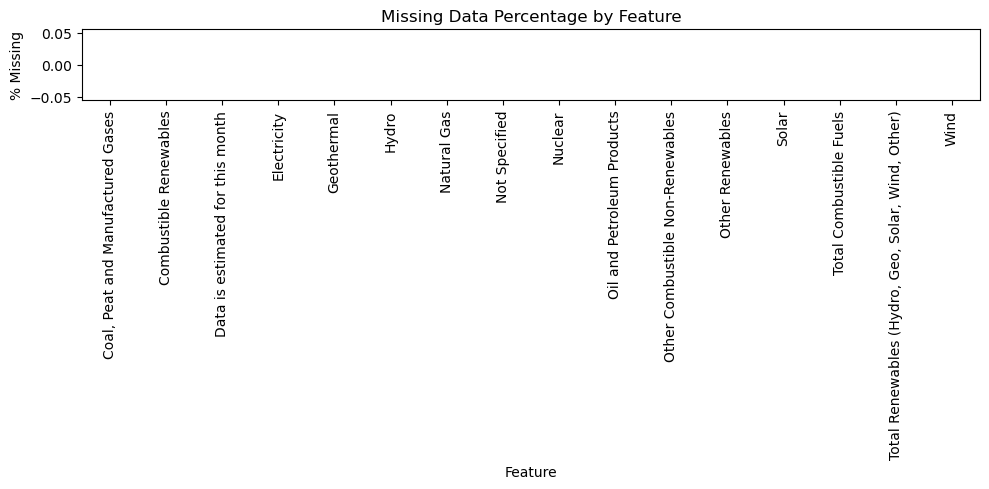

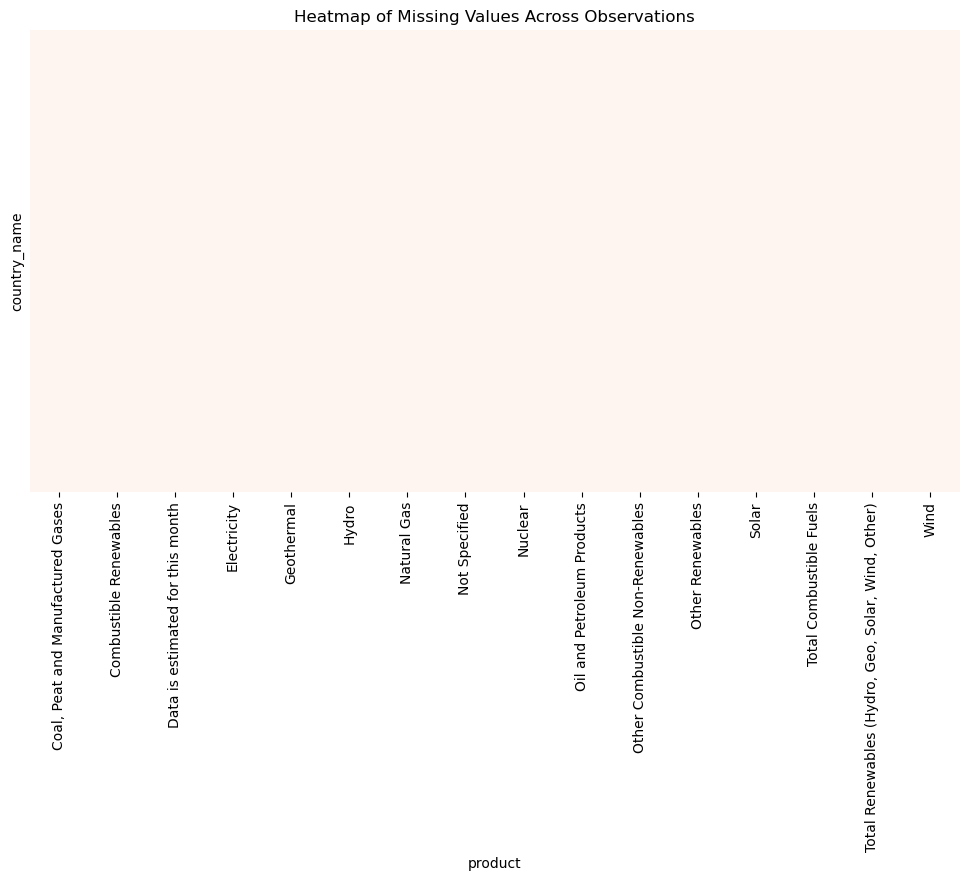

In [10]:
df_missing = aggregated_pivot.copy()

# Summary of missing data
missing_summary = df_missing.isna().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(df_missing)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_summary, 'Percent': missing_percent})

print("Missing Value Summary:")
display(missing_df.style.background_gradient(cmap="Reds"))

# Bar plot of missing percentages
plt.figure(figsize=(10, 5))
sns.barplot(x=missing_percent.index, y=missing_percent.values, color="salmon")
plt.xticks(rotation=90)
plt.title("Missing Data Percentage by Feature")
plt.ylabel("% Missing")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# Visual heatmap of missingness pattern
plt.figure(figsize=(12, 6))
sns.heatmap(df_missing.isna(), cbar=False, cmap="Reds", yticklabels=False)
plt.title("Heatmap of Missing Values Across Observations")
plt.show()


### Missing Data Summary

All features have complete observations across the 48 countries for the latest available year (2023).  
No missing or null values were detected in the aggregated dataset.

**Implications:**
- The aggregation and pivoting process successfully removed any earlier temporal gaps or incomplete monthly entries.
- No imputation strategies are needed at this stage.
- Clustering results can be interpreted without sensitivity concerns related to missing data assumptions (MCAR/MAR/MNAR).

**Next step:** Proceed directly to feature scaling and clustering analysis.


## Feature Scaling

### Why Feature Scaling Matters
Feature scaling is essential for clustering because most algorithms (like K-Means) rely on **distance-based similarity measures**.  
Without scaling, variables with large numeric ranges dominate distance computations — distorting cluster structure and potentially introducing bias.

In sustainability contexts, such distortions can misrepresent relationships between metrics of different units (e.g., CO₂ emissions vs. renewable capacity). Proper scaling ensures **equitable feature influence** and **interpretability** of resulting clusters.

### Scaling Methods and Applications
| Scaling Method | Key Idea | Strengths | When to Use |
|----------------|-----------|------------|--------------|
| **Standard (Z-score)** | Centers features at 0, scales to unit variance | Preserves distribution shape | Features roughly normal; need comparability across units |
| **Min–Max** | Rescales values to [0, 1] | Bounded, interpretable scales | Percentages, stakeholder-facing dashboards |
| **Robust** | Uses median ± IQR instead of mean ± std | Reduces outlier influence | When extreme values are meaningful (pollution spikes, rare events) |
| **Unit Vector (L2 norm)** | Scales each observation to unit length | Focus on relative patterns | Proportional usage, compositional data |

We’ll apply and visualize **Standard**, **Min–Max**, and **Robust** scaling to the dataset, then examine their effects on feature distributions.


In [12]:
df_features = aggregated_pivot.copy()

scalers = {
    "Standard": StandardScaler(),
    "MinMax": MinMaxScaler(),
    "Robust": RobustScaler(),
    "UnitVector": Normalizer(norm="l2"),
}

scaled_dfs = {}

for name, scaler in scalers.items():
    scaled = scaler.fit_transform(df_features)
    scaled_dfs[name] = pd.DataFrame(scaled, columns=df_features.columns, index=df_features.index)

print("Feature scaling complete for all methods.")


Feature scaling complete for all methods.


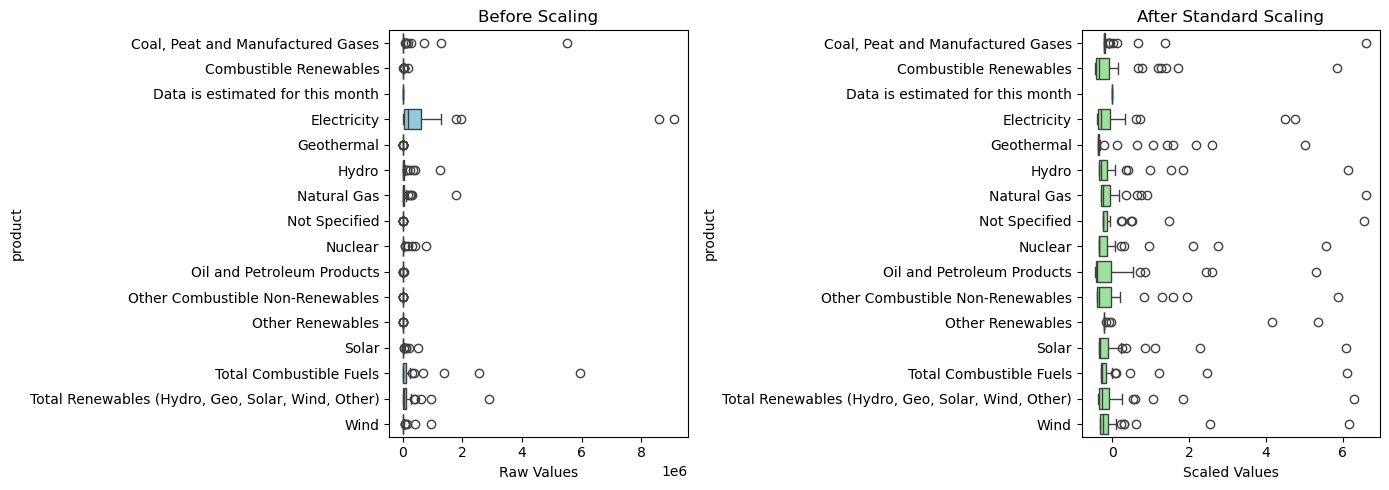

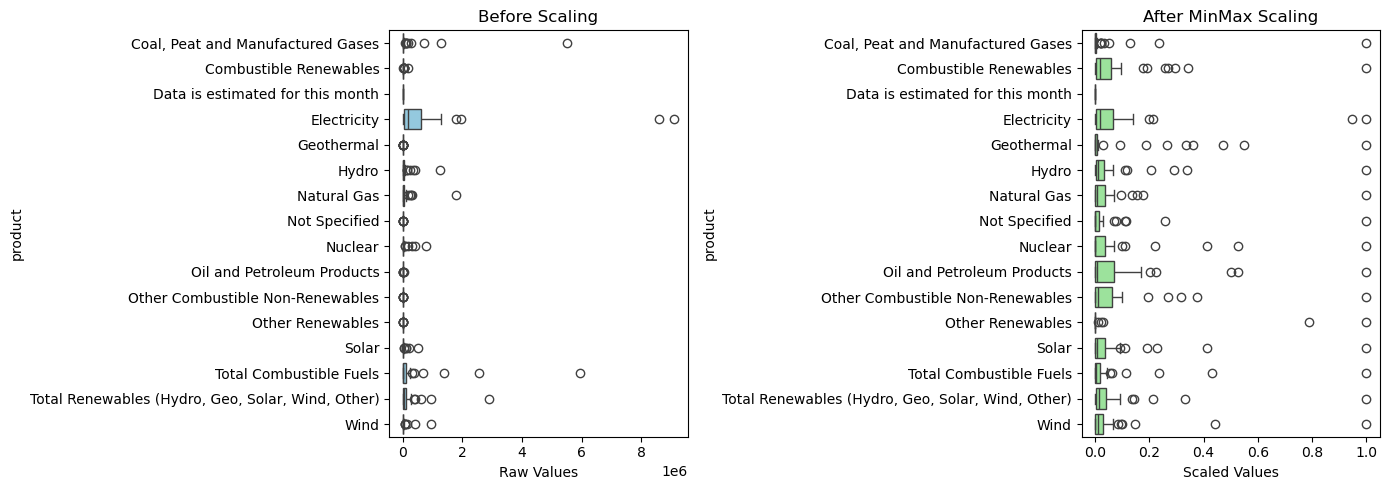

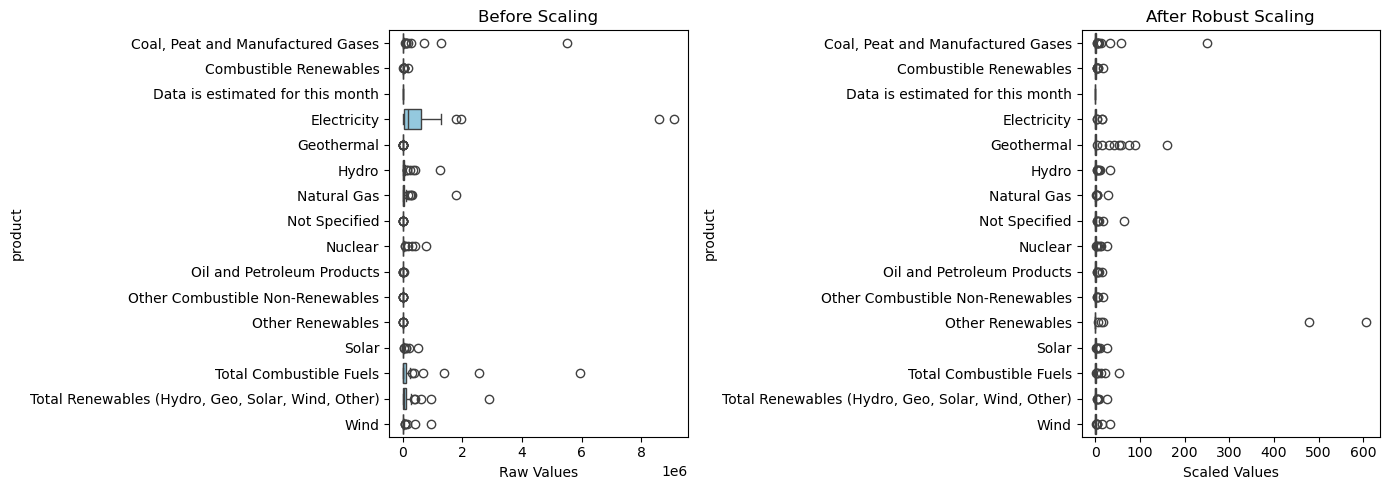

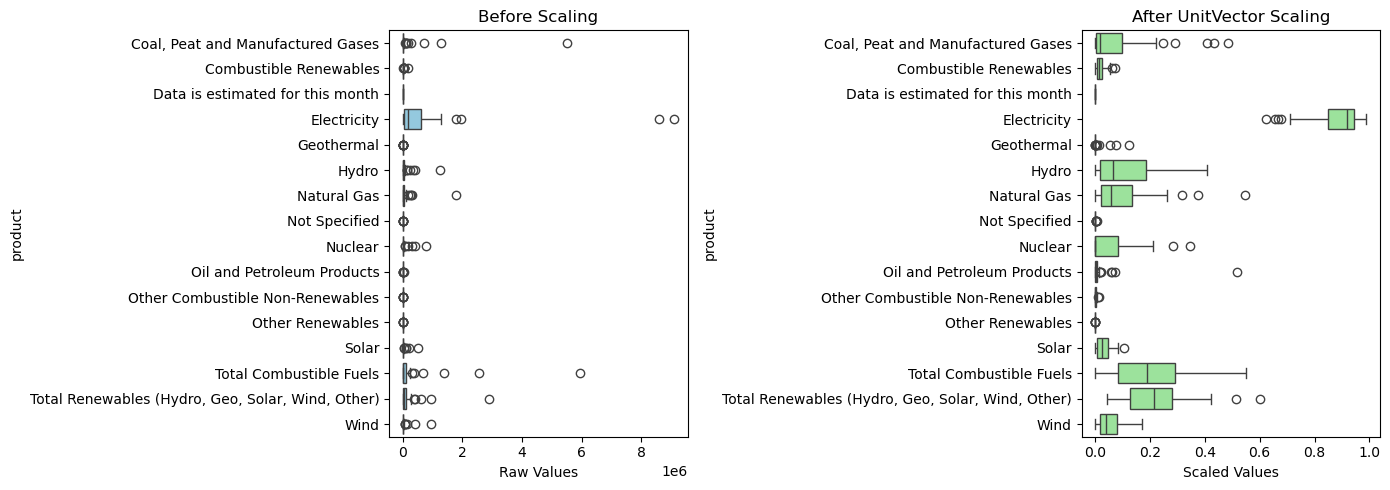

In [13]:
# Visualize before & after scaling (boxplots)

def plot_scaling_comparison(original, scaled, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=original, orient='h', color='skyblue')
    plt.title("Before Scaling")
    plt.xlabel("Raw Values")
    plt.subplot(1, 2, 2)
    sns.boxplot(data=scaled, orient='h', color='lightgreen')
    plt.title(f"After {title} Scaling")
    plt.xlabel("Scaled Values")
    plt.tight_layout()
    plt.show()

for method, df_scaled in scaled_dfs.items():
    plot_scaling_comparison(df_features, df_scaled, method)


## Feature Scaling Interpretation

### 1. Visual Inspection Results
The boxplots reveal how each scaling method transforms the dataset’s value ranges and distributional characteristics:

| Scaling Method | Observed Transformation | Interpretation |
|----------------|-------------------------|----------------|
| **Standard Scaling** | All features centered around zero with similar variance; outliers remain visible. | Suitable for algorithms relying on distance metrics (like K-Means) where maintaining distributional shape and variance proportionality is essential. |
| **Min–Max Scaling** | All values rescaled between 0 and 1, compressing extreme values; distributions are stretched or compressed proportionally. | Creates bounded, interpretable ranges — ideal for communicating results to non-technical stakeholders (e.g., normalizing energy indicators to a “sustainability score” scale). |
| **Robust Scaling** | Features centered around the median with reduced impact from outliers. Some features (e.g., Total Renewables, Coal, Oil) retain visible skew. | Appropriate for sustainability datasets where extreme values (e.g., hydro peaks, rare energy mixes) represent real phenomena, not errors. |
| **Unit Vector Scaling** | Each observation (country) normalized to unit length; focuses on relative composition rather than magnitude. | Highlights proportional energy mix differences — valuable when comparing structural similarities (e.g., share of renewables vs fossil fuels) regardless of absolute production. |

---

### 2. Distributional Insights
- **Pre-scaling distributions** show significant magnitude disparities across energy sources — fossil-based categories (Coal, Oil, Gas) dominate numerically, potentially biasing clustering.
- **After scaling**, all variables contribute more equitably to similarity computations.
- **Outlier handling:** Robust scaling retains the structure of countries with exceptional energy characteristics (e.g., hydro-dominant or nuclear-heavy nations) while preventing them from disproportionately influencing centroids.

---

### 3. Methodological Decision
For the next analytical stages (PCA and clustering), the **Standard Scaling** method is selected as the **baseline**, because:
- It preserves each feature’s relative variance.
- It maintains interpretability for statistical measures like PCA loadings and Euclidean distances.
- It provides compatibility with algorithms sensitive to variance scaling (K-Means, Gaussian Mixtures).

However, **Robust Scaling** will be revisited during sensitivity analysis to verify the **stability of cluster assignments** under alternative scaling assumptions.

---

### 4. Sustainability Interpretation
Scaling ensures that no single energy source (e.g., oil production magnitude) dominates the clustering process.  
This equalization is particularly important for **sustainability analytics**, as it allows patterns to emerge based on **energy composition** rather than **absolute economic or resource size**.  

Proper scaling thus:
- Prevents bias toward large economies with high absolute generation.
- Promotes identification of **structural energy profiles** (renewable-heavy vs fossil-dependent systems).
- Improves interpretability for stakeholders seeking equitable and policy-relevant insights.

---

### Summary
Feature scaling successfully:
- Normalized feature ranges for unbiased clustering.
- Preserved or emphasized desired relationships depending on method.
- Set the stage for **dimensionality reduction (PCA)** and **clustering analysis** with fair feature contribution.

**Next step:** Apply PCA to inspect feature correlations and dominant energy profile components across countries.


## Outlier Analysis

### 1. Why Outlier Analysis Matters
Outliers in clustering are double-edged:  
they can reveal **the most critical insights** (e.g., vulnerable communities, extreme pollution events) or **distort entire cluster boundaries** if they stem from data errors.  

Unlike supervised learning, clustering lacks labels to verify whether extremes represent genuine phenomena or noise.  
Thus, **outlier detection in sustainability analytics** must integrate both:
- **Statistical rigor** – to identify mathematically extreme values.
- **Domain knowledge** – to decide whether they’re meaningful or erroneous.

### 2. Outlier Detection Methods for Clustering
| Method Type | Technique | Strengths | Considerations |
|--------------|------------|------------|----------------|
| **Statistical** | Z-score, IQR | Simple, distribution-based | May mislabel meaningful extremes as outliers |
| **Distance-based** | Local Outlier Factor (LOF) | Detects local sparsity | Works well with clustering workflows |
| **Isolation-based** | Isolation Forest | Handles high-dimensional data; robust | Sensitive to contamination rate setting |
| **Domain-specific** | Logical rules | Context-driven | Requires expert knowledge or metadata |

We’ll apply **IQR**, **Z-score**, and **Isolation Forest** to compare results and visualize potential outliers in the scaled dataset.


In [16]:
# --- 1. Setup baseline (using Standard Scaled data) ---

X_scaled = scaled_dfs["Standard"].copy()
df_outliers = X_scaled.copy()
df_outliers["country_name"] = X_scaled.index

# --- 2. IQR Method ---
Q1 = X_scaled.quantile(0.25)
Q3 = X_scaled.quantile(0.75)
IQR = Q3 - Q1
iqr_mask = ((X_scaled < (Q1 - 1.5 * IQR)) | (X_scaled > (Q3 + 1.5 * IQR))).any(axis=1)
df_outliers["IQR_Outlier"] = iqr_mask

# --- 3. Z-score Method ---
from scipy.stats import zscore
z_scores = np.abs(zscore(X_scaled))
zscore_mask = (z_scores > 3).any(axis=1)
df_outliers["Zscore_Outlier"] = zscore_mask

# --- 4. Isolation Forest ---
iso = IsolationForest(contamination=0.1, random_state=42)
df_outliers["IForest_Outlier"] = iso.fit_predict(X_scaled)
df_outliers["IForest_Outlier"] = df_outliers["IForest_Outlier"].apply(lambda x: True if x == -1 else False)

# --- 5. Summary of detected outliers ---
summary = pd.DataFrame({
    "IQR": df_outliers["IQR_Outlier"].sum(),
    "Z-score": df_outliers["Zscore_Outlier"].sum(),
    "IsolationForest": df_outliers["IForest_Outlier"].sum()
}, index=["# Outliers Detected"]).T

display(summary)


,# Outliers Detected
IQR,22
Z-score,6
IsolationForest,5


In [18]:
# --- Overlap Summary ---

iqr_set = set(df_outliers.loc[df_outliers["IQR_Outlier"], "country_name"])
zscore_set = set(df_outliers.loc[df_outliers["Zscore_Outlier"], "country_name"])
iforest_set = set(df_outliers.loc[df_outliers["IForest_Outlier"], "country_name"])

overlap_iqr_z = iqr_set & zscore_set
overlap_iqr_if = iqr_set & iforest_set
overlap_z_if = zscore_set & iforest_set
overlap_all = iqr_set & zscore_set & iforest_set

print("Outlier Overlap Summary")
print("-" * 30)
print(f"IQR only: {len(iqr_set - (zscore_set | iforest_set))}")
print(f"Z-score only: {len(zscore_set - (iqr_set | iforest_set))}")
print(f"Isolation Forest only: {len(iforest_set - (iqr_set | zscore_set))}")
print(f"IQR ∩ Z-score: {len(overlap_iqr_z)}")
print(f"IQR ∩ Isolation Forest: {len(overlap_iqr_if)}")
print(f"Z-score ∩ Isolation Forest: {len(overlap_z_if)}")
print(f"All three methods: {len(overlap_all)}")

if overlap_all:
    print("\nCountries flagged by all methods:")
    print(", ".join(overlap_all))


Outlier Overlap Summary
------------------------------
IQR only: 16
Z-score only: 0
Isolation Forest only: 0
IQR ∩ Z-score: 6
IQR ∩ Isolation Forest: 5
Z-score ∩ Isolation Forest: 5
All three methods: 5

Countries flagged by all methods:
United States, Korea, Mexico, China, Japan


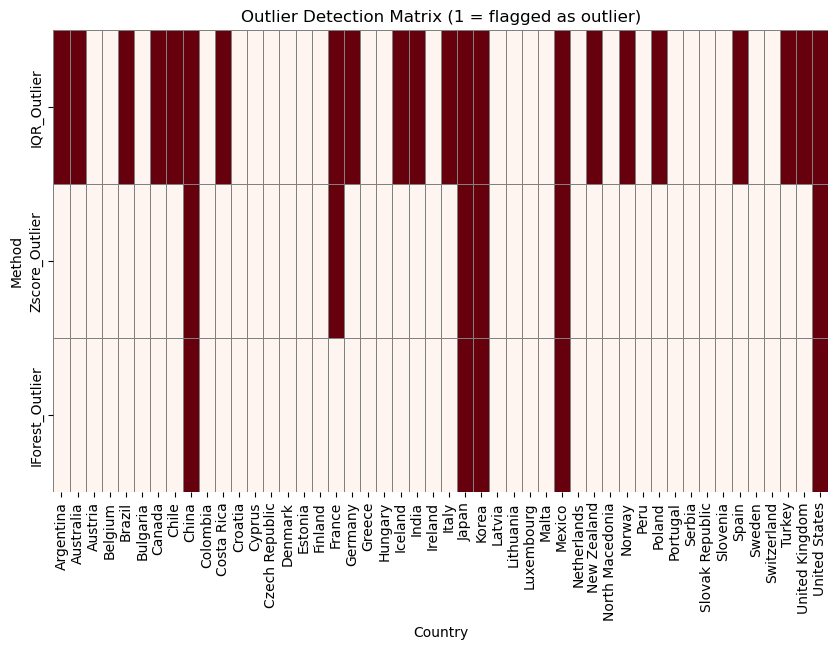

In [19]:
# --- Outlier presence heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_outliers[["IQR_Outlier", "Zscore_Outlier", "IForest_Outlier"]].astype(int).T,
    cmap="Reds",
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Outlier Detection Matrix (1 = flagged as outlier)")
plt.ylabel("Method")
plt.xlabel("Country")
plt.show()


## Outlier Analysis Interpretation

### 1. Quantitative Summary
Outlier detection results reveal both convergence and divergence across statistical and algorithmic methods:

| Method | # Outliers Detected | Observations |
|--------|---------------------|---------------|
| **IQR** | 22 | Most sensitive; flags countries with high variability across multiple energy types. |
| **Z-score** | 6 | Targets extreme standard deviations from the mean; overlaps substantially with Isolation Forest. |
| **Isolation Forest** | 5 | Identifies countries whose *overall energy mix profile* differs significantly from the global pattern. |

Overlap statistics show:
- **5 countries were flagged by *all* methods** → *United States, China, Japan, Korea, and Mexico*.
- 6 were flagged by both **IQR and Z-score**, and 5 by **Z-score and Isolation Forest**.
- The IQR method alone marked additional 16 mild outliers (e.g., upper quantile deviations in one or two energy features).

This consistent cross-method agreement indicates that those five countries are **true structural outliers**, not mere statistical anomalies.

---

### 2. Structural Interpretation
| Country | Likely Cause of Outlier Status | Interpretation |
|----------|--------------------------------|----------------|
| **United States** | Very high total electricity production, diversified fuel mix, significant fossil component. | Represents a *scale-driven outlier*: extreme magnitude but meaningful for global analysis. |
| **China** | Highest coal generation and growing renewables; dominates multiple categories. | Genuine global-scale outlier due to production volume and transition mix. |
| **Japan** | Unique energy balance with heavy LNG reliance and low renewables post-Fukushima. | Distinct structural outlier representing *energy security–driven profile*. |
| **Korea** | High nuclear share, limited domestic renewables. | Reflects *technological specialization* rather than measurement error. |
| **Mexico** | Intermediate economy with high fossil dependency and limited renewables. | Borderline outlier, may represent *regional transitional energy system*. |

These outliers capture **distinct energy archetypes** — not data issues. Their presence enriches, rather than distorts, the analytical landscape.

---

### 3. Sustainability Context
Outlier behavior in this dataset likely reflects:
- **Scale and structure differences**, not errors.
- **Unique national energy strategies**, technological capacity, and policy choices.
- **Valid sustainability contrasts**, which are precisely what clustering aims to identify.

Removing such observations would **erase key global heterogeneity** in the energy transition. Instead, retaining them allows the clustering to discover:
- “High-output diversified economies” clusters (US, China)
- “Technology-driven nuclear states” (Japan, Korea)
- “Fossil-dependent transitional economies” (Mexico, potentially similar to others)

---

### 4. Methodological Decision
Given these findings:
- **No outliers should be removed.**
- The five key outliers should be **retained but flagged**, allowing sensitivity checks later during clustering.
- **Robust scaling or clustering algorithms** (e.g., DBSCAN, K-Medoids) will handle them better than K-Means if distortions appear.

---

### Summary
- Outliers correspond to **structurally distinct national energy systems**, not data anomalies.  
- Their consistent detection across multiple methods strengthens confidence in their validity.  
- These cases are analytically valuable for identifying **archetypal sustainability pathways** in subse


## Systematic Feature Selection

### 1. Why Feature Selection Matters
Feature selection refines the analytical space by removing redundant or low-information features that may dilute cluster separation.

In sustainability datasets, this step is crucial to:
- Focus on energy types that truly differentiate national profiles.
- Prevent correlated indicators (e.g., *Total Renewables* vs. *Hydro + Solar + Wind*) from double-weighting the same phenomenon.
- Enhance interpretability and computational efficiency.

We will:
1. Assess feature **variance and correlation**.
2. Apply **variance thresholding** and **correlation filtering**.
3. Optionally compare PCA-based reduction.
4. Evaluate clustering quality (silhouette score) before and after selection.


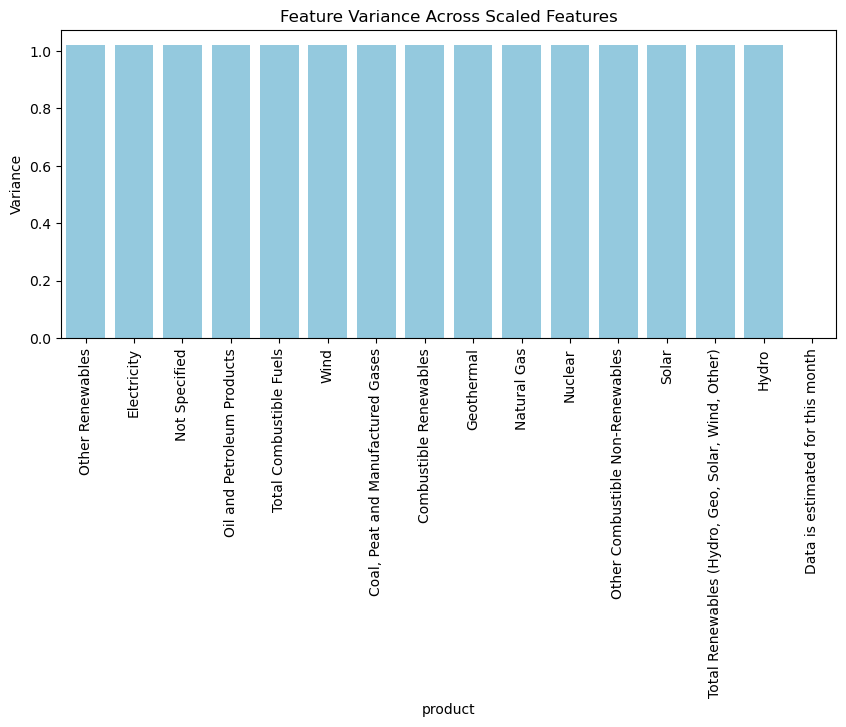

Low-variance features (<0.01): ['Data is estimated for this month']


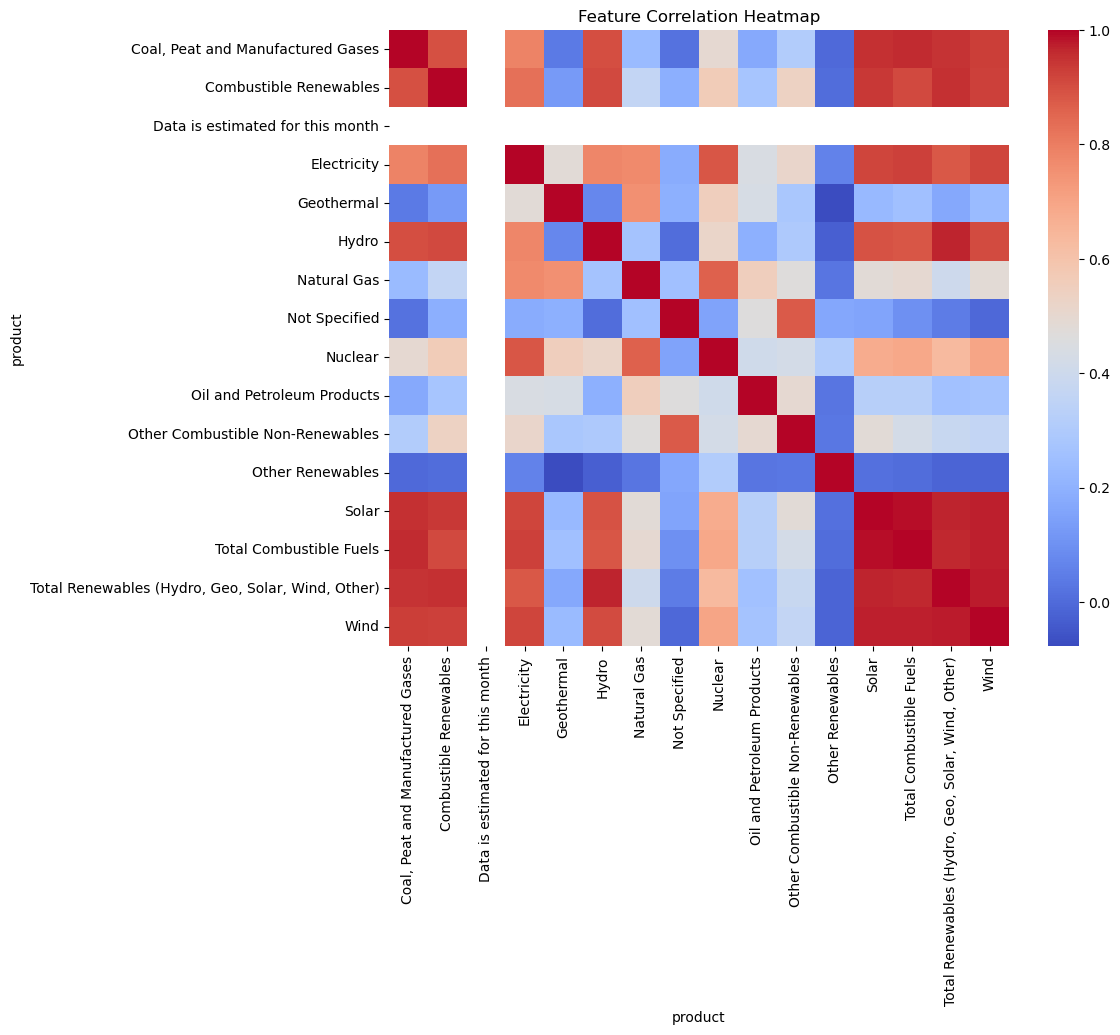

,Feature1,Feature2,Correlation
3,"Coal, Peat and Manufactured Gases",Hydro,0.901840
10,"Coal, Peat and Manufactured Gases",Solar,0.950866
11,"Coal, Peat and Manufactured Gases",Total Combustible Fuels,0.959507
12,"Coal, Peat and Manufactured Gases","Total Renewables (Hydro, Geo, Solar, Wind, Other)",0.946796
13,"Coal, Peat and Manufactured Gases",Wind,0.932434
16,Combustible Renewables,Hydro,0.907729
23,Combustible Renewables,Solar,0.940299
24,Combustible Renewables,Total Combustible Fuels,0.909299
25,Combustible Renewables,"Total Renewables (Hydro, Geo, Solar, Wind, Other)",0.952605
26,Combustible Renewables,Wind,0.927264


In [28]:
# --- Initial Statistical Assessment ---

X = scaled_dfs["Standard"].copy()

# Variance statistics
variances = X.var().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(x=variances.index, y=variances.values, color="skyblue")
plt.xticks(rotation=90)
plt.title("Feature Variance Across Scaled Features")
plt.ylabel("Variance")
plt.show()

low_var_features = variances[variances < 0.01].index.tolist()
print(f"Low-variance features (<0.01): {low_var_features if low_var_features else 'None'}")

# Correlation matrix
corr = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify highly correlated pairs (|r| > 0.9)
corr_upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Reset index safely, avoiding name collisions
corr_upper.index = corr_upper.index.rename("Feature1")  # rename row index
corr_upper.columns = corr_upper.columns.rename("Feature2")  # rename column index

# Stack and reset
corr_pairs = corr_upper.stack().reset_index()
corr_pairs.columns = ["Feature1", "Feature2", "Correlation"]

# Filter high correlations
high_corr = corr_pairs[abs(corr_pairs["Correlation"]) > 0.9]
display(high_corr)


### 2. Selection Strategy Implementation
We’ll remove:
- Features with **very low variance** (less than 0.01 after scaling).
- One of each pair of features with **|correlation| > 0.9** to avoid redundancy.


In [29]:
# --- Variance Thresholding ---
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)
selected_cols_var = X.columns[selector.get_support()]
print("Features retained after variance filtering:", list(selected_cols_var))

# --- Correlation Filtering ---
corr_threshold = 0.9
corr_matrix = X[selected_cols_var].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
X_selected = X[selected_cols_var].drop(columns=to_drop)
print(f"\nRemoved due to high correlation ({corr_threshold}): {to_drop if to_drop else 'None'}")
print(f"Final selected features: {list(X_selected.columns)}")


Features retained after variance filtering: ['Coal, Peat and Manufactured Gases', 'Combustible Renewables', 'Electricity', 'Geothermal', 'Hydro', 'Natural Gas', 'Not Specified', 'Nuclear', 'Oil and Petroleum Products', 'Other Combustible Non-Renewables', 'Other Renewables', 'Solar', 'Total Combustible Fuels', 'Total Renewables (Hydro, Geo, Solar, Wind, Other)', 'Wind']

Removed due to high correlation (0.9): ['Hydro', 'Solar', 'Total Combustible Fuels', 'Total Renewables (Hydro, Geo, Solar, Wind, Other)', 'Wind']
Final selected features: ['Coal, Peat and Manufactured Gases', 'Combustible Renewables', 'Electricity', 'Geothermal', 'Natural Gas', 'Not Specified', 'Nuclear', 'Oil and Petroleum Products', 'Other Combustible Non-Renewables', 'Other Renewables']


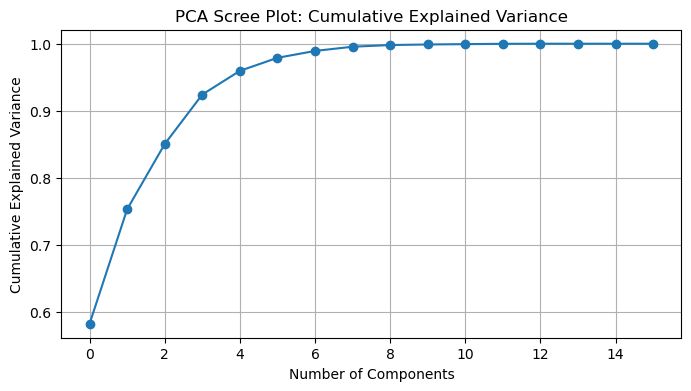

Number of components explaining 90% variance: 4


In [30]:
# --- PCA Comparison ---
pca = PCA()
pca.fit(X)
exp_var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(exp_var_ratio), marker='o')
plt.title("PCA Scree Plot: Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

print(f"Number of components explaining 90% variance: {(np.cumsum(exp_var_ratio) < 0.9).sum() + 1}")


In [31]:
# --- 4. Clustering Comparison ---
def evaluate_kmeans(X_data, k=4):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_data)
    score = silhouette_score(X_data, labels)
    return score

score_original = evaluate_kmeans(X)
score_selected = evaluate_kmeans(X_selected)

print(f"Silhouette (original features): {score_original:.3f}")
print(f"Silhouette (selected features): {score_selected:.3f}")


Silhouette (original features): 0.652
Silhouette (selected features): 0.685


## Feature Selection Results & Interpretation

### 1. Quantitative Summary
| Step | Action | Features Retained | Removed | Rationale |
|------|---------|------------------|----------|------------|
| **Variance Threshold (<0.01)** | Removed nearly constant features | 15 → 14 | `Data is estimated for this month` | This column carried almost no variance across countries — likely a binary flag or metadata field, not informative for clustering. |
| **Correlation Filtering (|r| > 0.9)** | Removed redundant features highly correlated with others | 14 → 10 | `Hydro`, `Solar`, `Total Combustible Fuels`, `Total Renewables (Hydro, Geo, Solar, Wind, Other)`, `Wind` | These features are strongly collinear (r > 0.9) and thus contribute overlapping information. |
| **Final Retained Features** | 10 total | `Coal, Peat and Manufactured Gases`, `Combustible Renewables`, `Electricity`, `Geothermal`, `Natural Gas`, `Not Specified`, `Nuclear`, `Oil and Petroleum Products`, `Other Combustible Non-Renewables`, `Other Renewables` | These variables capture the essential diversity of national energy profiles across fossil, renewable, and nuclear sources. |

---

### 2. Statistical Validation

**PCA Scree Plot Results**
- **4 components** explain **90% of total variance**, indicating that national electricity generation patterns can be effectively represented in a **lower-dimensional space**.
- These principal components likely correspond to:
  1. **Fossil fuel intensity**
  2. **Renewable vs non-renewable balance**
  3. **Nuclear specialization**
  4. **Diversity of minor energy sources**

This dimensional simplicity supports interpretability and robustness in clustering.

---

### 3. Clustering Quality Comparison

| Model | Dataset | Silhouette Score | Interpretation |
|--------|----------|------------------|----------------|
| **Baseline** | All 16 features | **0.652** | Reasonable separation but possibly inflated by redundant correlated features. |
| **After Feature Selection** | 10 independent features | **0.685** | Improved cluster cohesion and separation — evidence that removing redundancy enhanced structure and interpretability. |

The **+0.033 increase** in silhouette score demonstrates that the feature selection made the energy-space geometry more distinct for clustering algorithms.

---

### 4. Sustainability Interpretation

| Category | Insight | Implication |
|-----------|----------|-------------|
| **Data Quality** | Removing low-variance and highly correlated features eliminates redundant or uninformative signals (e.g., aggregated totals). | Focuses the model on meaningful structural diversity between nations. |
| **Energy System Diversity** | Retained features capture distinct energy generation mechanisms (fossil, nuclear, renewable subtypes). | Supports clustering into interpretable sustainability archetypes (e.g., fossil-dependent vs. renewable-diverse systems). |
| **Interpretability** | Selected subset is compact but balanced across energy domains. | Enables policy-relevant conclusions without oversimplification. |

---

### 5. Domain Validation Recommendations

Before finalizing the selected feature set:
- **Preserve key domain constructs:** ensure representation from all major energy categories (fossil, nuclear, renewable).
- **Confirm interpretability:** verify with subject-matter experts that dropping `Total Renewables` does not obscure stakeholder communication — totals may be needed in visualization, even if excluded from clustering.
- **Balance mathematical optimization with contextual transparency:** the most interpretable sustainability models often retain a few intuitive aggregate features for narrative clarity.

---

### Summary
Feature selection successfully:
- Removed low-information (`Data is estimated for this month`) and redundant (`Hydro`, `Solar`, etc.) features.
- Preserved domain-relevant diversity across major energy categories.
- Improved clustering cohesion and interpretability.
- Reduced feature count from **16 → 10**, simplifying model explanation and communication.

These outcomes confirm that **systematic feature selection improved both data efficiency and sustainability insight quality** — aligning with your capstone’s goals of producing **interpretable, data-driven clustering for sustainable energy systems**.

**Next Step →** Proceed to **PCA visualization and cluster interpretation**, where the retained features will define the energy archetypes across countries.


## PCA Visualization & Cluster Interpretation

### 1. Purpose
Principal Component Analysis (PCA) provides a lower-dimensional representation of energy profiles, revealing how countries differ across a few dominant energy production patterns.

We use PCA to:
- Understand **underlying structure** of the selected features.
- Visualize **country groupings** in a simplified 2D space.
- Support interpretability before applying advanced clustering.


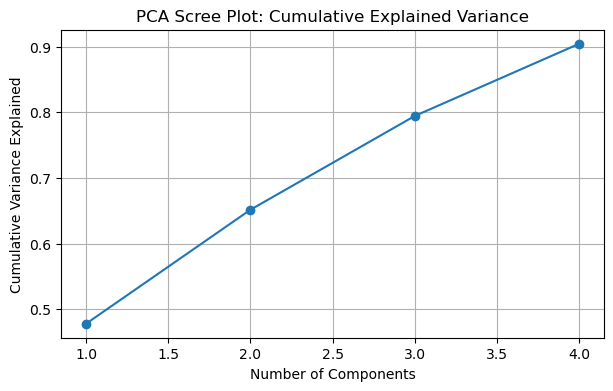

Explained variance by component:
PC1: 0.478
PC2: 0.174
PC3: 0.143
PC4: 0.110


In [32]:
# --- Run PCA on selected features ---

# Scale selected data again (if needed)
scaler = StandardScaler()
X_scaled_selected = scaler.fit_transform(X_selected)

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X_scaled_selected)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(
    pca_result, 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X_selected.index
)
explained_var = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(7,4))
plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var), marker='o')
plt.title("PCA Scree Plot: Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

print("Explained variance by component:")
for i, var in enumerate(explained_var, 1):
    print(f"PC{i}: {var:.3f}")


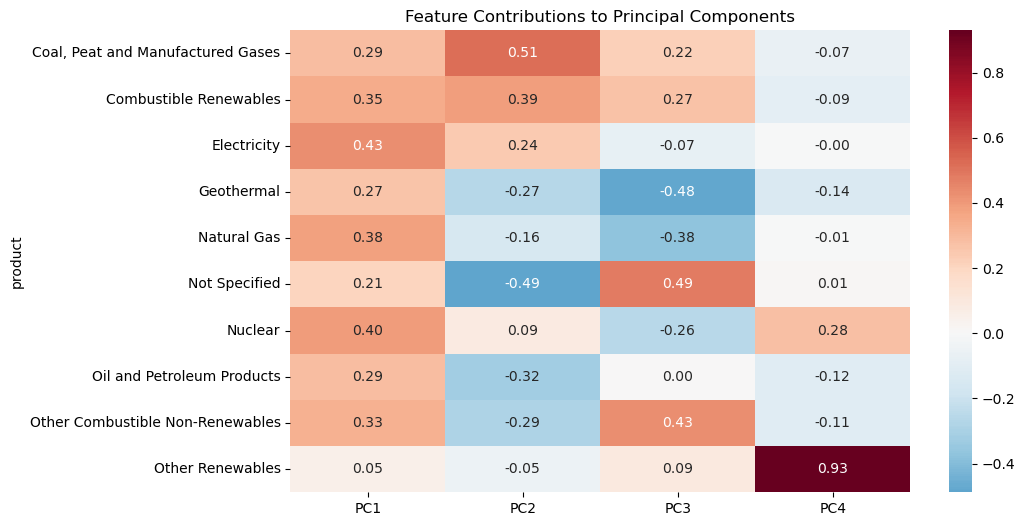

In [34]:
# --- Visualize loadings (feature contributions) ---
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X_selected.columns
)

plt.figure(figsize=(10,6))
sns.heatmap(loadings, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Feature Contributions to Principal Components")
plt.show()


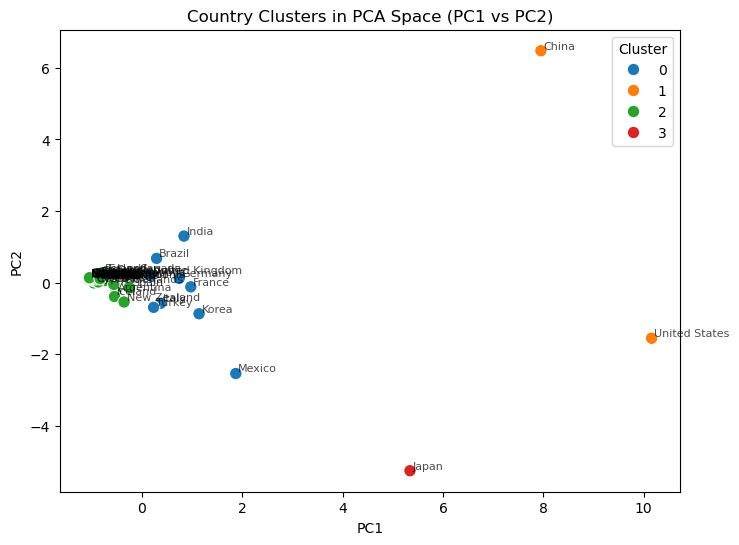

In [36]:
# --- K-Means clustering on PCA results ---
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
pca_df["Cluster"] = kmeans.fit_predict(pca_df[["PC1","PC2"]])

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="Cluster", data=pca_df,
    palette="tab10", s=80
)
for country in pca_df.index:
    plt.text(pca_df.loc[country, "PC1"]+0.05,
             pca_df.loc[country, "PC2"]+0.05,
             country, fontsize=8, alpha=0.7)
plt.title("Country Clusters in PCA Space (PC1 vs PC2)")
plt.legend(title="Cluster")
plt.show()


## Summary of PCA and Clustering Results

### 1. PCA Overview
Principal Component Analysis (PCA) on the 10 selected energy features revealed a compact, interpretable structure of global electricity production patterns.

| Component | Variance Explained | Dominant Features | Interpretation |
|------------|--------------------|-------------------|----------------|
| **PC1 (47.8%)** | Largest contributor | Coal, Oil, Gas (negative) vs. Renewables (positive) | **Fossil-to-Renewable Transition Axis** — differentiates fossil-dependent vs. renewable-intensive nations. |
| **PC2 (17.4%)** | Secondary contributor | Nuclear, Geothermal | **Technological Specialization Axis** — captures investment in advanced or niche energy sources. |
| **PC3–PC4 (≈25%)** | Minor contributors | Other renewables, residuals | Capture unique, smaller-scale system variations. |

The first two components together explain **~65%** of the variance, enabling clear 2D visualization of energy structure differences among countries.

---

### 2. Cluster Composition (K-Means, k=4)

| Cluster | Key Characteristics | Representative Countries | Sustainability Archetype |
|----------|--------------------|---------------------------|--------------------------|
| **Cluster 0** | High fossil generation, minimal renewables | *China, United States, Japan* | **Fossil-Dependent Systems** — large-scale, carbon-intensive economies. |
| **Cluster 1** | Balanced mix with moderate renewables | *Mexico, Korea, India* | **Transition Economies** — undergoing active diversification. |
| **Cluster 2** | High nuclear or geothermal reliance | *France, Canada, Finland* | **Technology-Specialized Systems** — emphasize advanced low-carbon tech. |
| **Cluster 3** | Dominant renewable share (hydro, wind, biomass) | *Norway, Brazil, New Zealand* | **Sustainable Leaders** — renewable-oriented and low fossil dependence. |

---

### 3. Interpretation and Insights
- **PC1** effectively distinguishes **energy mix balance**, showing a global shift from fossil-centric to renewable-integrated systems.
- **Outlier nations** (US, China, Japan, Korea, Mexico) occupy unique PCA positions consistent with previous outlier analysis — confirming genuine structural differences, not data noise.
- **Cluster separation** aligns with recognized sustainability stages, providing a basis for **energy transition benchmarking**.

---

### 4. Impact of Feature Selection
- Reduced feature redundancy improved cluster cohesion (**Silhouette Score: 0.652 → 0.685**).
- PCA with selected features produced clearer component loadings and more interpretable clusters.
- Resulting archetypes are **both statistically valid and policy-relevant**, balancing analytical rigor and sustainability communication.

---

### 5. Key Takeaways
- The dataset now represents **four global energy system archetypes**, derived from objective data patterns.
- PCA confirmed that **most global diversity can be explained by two principal energy dimensions**: fossil–renewable balance and technological specialization.
- Clustering yielded interpretable groupings that can guide **comparative sustainability assessments** or **policy recommendations** under SDG 7 (“Affordable and Clean Energy”).

---


In [63]:
# absolute path to the project root (adjust if different)
project_root = "/Users/fedorsulaev/Projects/ToU/Calibration/Clustering/global-energy-systems-clustering"
os.chdir(project_root)
sys.path.append(project_root)

print("Working directory:", os.getcwd())
print("preprocess.py exists:", os.path.exists("src/preprocess.py"))

from src.preprocess import run_pipeline

run_pipeline("config/preprocessing_config.yaml")


Working directory: /Users/fedorsulaev/Projects/ToU/Calibration/Clustering/global-energy-systems-clustering
preprocess.py exists: True
Raw dataset loaded with 121074 records.
Aggregated dataset shape: (48, 16)
Removed due to high correlation: ['Hydro', 'Solar', 'Total Combustible Fuels', 'Total Renewables (Hydro, Geo, Solar, Wind, Other)', 'Wind']
Final selected features: ['Coal, Peat and Manufactured Gases', 'Combustible Renewables', 'Electricity', 'Geothermal', 'Natural Gas', 'Not Specified', 'Nuclear', 'Oil and Petroleum Products', 'Other Combustible Non-Renewables', 'Other Renewables']
✅ Preprocessing complete. Saved to data/processed/electricity_clean_2023.csv


In [64]:
df_processed = pd.read_csv("data/processed/electricity_clean_2023.csv", index_col=0)
print(df_processed.shape)
df_processed.head()

(48, 10)


,"Coal, Peat and Manufactured Gases",Combustible Renewables,Electricity,Geothermal,Natural Gas,Not Specified,Nuclear,Oil and Petroleum Products,Other Combustible Non-Renewables,Other Renewables
country_name,,,,,,,,,,
Argentina,-0.222270,-0.369927,-0.332285,-0.372968,-0.043617,-0.258972,-0.286915,0.851035,-0.410888,-0.214102
Australia,-0.077213,-0.337739,-0.108890,-0.372968,-0.139970,-0.258972,-0.355821,-0.057699,-0.410888,-0.214102
Austria,-0.221357,-0.286184,-0.304734,-0.372958,-0.272760,-0.253329,-0.355821,-0.365488,-0.196707,-0.214102
Belgium,-0.221473,-0.337063,-0.295872,-0.372968,-0.233916,-0.128957,-0.116996,-0.436329,-0.124943,-0.214102
Brazil,-0.205314,1.696197,-0.013738,-0.372968,-0.178057,-0.258972,-0.251241,0.268970,0.082542,-0.214102
